In [ ]:
# Example of how the historical data affects default values

import json
import numpy as np
from datetime import datetime, timedelta

# Sample historical data
sample_data = {
    'EDUCATION': {
        'default_rates': [9.8, 10.2, 9.9, 10.5],
        'interest_rates': [7.2, 7.8, 7.5, 7.6],
        'loan_amounts': [32000, 34000, 33500, 35000],
        'timestamps': [
            (datetime.now() - timedelta(days=x)).isoformat()
            for x in [80, 60, 30, 1]
        ]
    }
}

# Calculate weighted average (recent values weighted more)
def calculate_weighted_average(values):
    weights = np.linspace(0.5, 1.0, len(values))
    return np.average(values, weights=weights)

# Calculate confidence score
def calculate_confidence(values, timestamps):
    max_samples = 30
    sample_confidence = min(len(values) / max_samples, 1.0)
    
    latest_date = datetime.fromisoformat(timestamps[-1])
    days_old = (datetime.now() - latest_date).days
    age_factor = max(0, (90 - days_old) / 90)
    
    return sample_confidence * age_factor

# Print statistics
for metric in ['default_rates', 'interest_rates', 'loan_amounts']:
    values = sample_data['EDUCATION'][metric]
    timestamps = sample_data['EDUCATION']['timestamps']
    
    weighted_avg = calculate_weighted_average(values)
    confidence = calculate_confidence(values, timestamps)
    
    print(f"\n{metric.upper()}:")
    print(f"Weighted Average: {weighted_avg:.2f}")
    print(f"Confidence Score: {confidence:.2f}")
    print(f"Use Historical: {'Yes' if confidence > 0.5 else 'No'}")
    print(f"Save to History: {'Yes' if confidence > 0.7 else 'No'}")


In [9]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

# Load sample data
try:
    with open('historical_loan_data.json', 'r') as f:
        historical_data = json.load(f)
    print("Successfully loaded historical data")
except FileNotFoundError:
    print("No historical data found yet - run the crawler first")


Successfully loaded historical data


In [10]:
# Example function demonstrating the improved validation logic
def validate_and_process_rates(rates, rate_type='default'):
    if not rates:
        return None, 0.0
    
    # Convert to numpy array
    rates = np.array(rates)
    
    # Calculate IQR
    q1 = np.percentile(rates, 25)
    q3 = np.percentile(rates, 75)
    iqr = q3 - q1
    
    # Define bounds
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    
    # Filter outliers
    filtered_rates = rates[(rates >= lower_bound) & (rates <= upper_bound)]
    
    if len(filtered_rates) < 3:
        return None, 0.0
    
    # Calculate weighted average (recent values weighted more)
    weights = np.linspace(0.5, 1.0, len(filtered_rates))
    weighted_avg = np.average(filtered_rates, weights=weights)
    
    # Calculate confidence score
    confidence = min(len(filtered_rates) / 3, 1.0)  # Normalized by minimum sample size
    
    return weighted_avg, confidence

# Example usage with sample data
sample_rates = [5.2, 5.5, 5.1, 15.0, 5.3, 5.4]  # 15.0 is an outlier
avg_rate, confidence = validate_and_process_rates(sample_rates)
print(f"Average Rate: {avg_rate:.2f}%")
print(f"Confidence Score: {confidence:.2f}")


Average Rate: 5.31%
Confidence Score: 1.00


In [11]:
# Function to analyze trends from historical data
def analyze_trends(historical_data, loan_type, metric):
    if not historical_data.get('loan_data'):
        return None, None
    
    # Extract timestamps and values
    data_points = []
    dates = []
    for timestamp, data in historical_data['loan_data'].items():
        if loan_type in data and metric in data[loan_type]:
            try:
                value = float(data[loan_type][metric])
                date = datetime.fromisoformat(timestamp)
                data_points.append(value)
                dates.append(date)
            except (ValueError, TypeError):
                continue
    
    if len(data_points) < 2:
        return None, None
    
    # Calculate trend
    x = np.arange(len(data_points))
    trend = np.polyfit(x, data_points, 1)[0]
    
    return data_points, trend

# Example visualization (if historical data exists)
if 'historical_data' in locals():
    loan_type = 'EDUCATION'
    metric = 'default_rate'
    
    values, trend = analyze_trends(historical_data, loan_type, metric)
    
    if values and trend is not None:
        plt.figure(figsize=(10, 6))
        plt.plot(values, marker='o')
        plt.title(f'{loan_type} {metric.replace("_", " ").title()} Trend')
        plt.ylabel(metric.replace("_", " ").title())
        plt.xlabel('Time Points')
        
        if trend > 0:
            trend_direction = "Increasing"
        else:
            trend_direction = "Decreasing"
        
        plt.text(0.02, 0.98, f'Trend: {trend_direction} ({trend:.3f})',
                transform=plt.gca().transAxes, verticalalignment='top')
        plt.grid(True)
        plt.show()


# Web Crawling Documentation for Credit Risk Feature Enhancement

This notebook documents our web crawling process to enhance the credit risk dataset with additional risk-related features. We use a comprehensive web crawler implemented in `real_web_crawler.py`.

## Why Web Crawling?

The original credit risk dataset lacks certain contextual risk factors that could improve prediction accuracy:

1. **Loan Intent Risk**: Different loan purposes carry different risk levels based on market statistics
2. **Home Ownership Risk**: Different ownership types have varying stability and default patterns

By web crawling reliable financial websites, we can add these contextual risk factors to our model.


## 1. Loan and Home Ownership Data Crawler

### Data Sources

#### Loan Intent Data:
- Bankrate.com: Interest rates and loan statistics
- NerdWallet.com: Loan comparisons and risk analysis
- LendingTree.com: Market offers and default rates
- Credible.com: Student loan specific data
- Fundera.com: Business loan statistics

#### Home Ownership Data:
- Bankrate's rent vs. buy calculator
- NerdWallet's mortgage rates
- LendingTree's home mortgage section

### Features Generated

1. **loan_intent_risk_score** (range: 0.26-0.37)
   - Based on:
     * Default rates by loan type
     * Average interest rates
     * Typical loan amounts

2. **home_ownership_risk_score** (range: 0.17-0.44)
   - Based on:
     * Stability scores
     * Historical default rates
     * Market trends

3. **combined_risk_score** (range: 0.22-0.40)
   - Weighted combination:
     * 60% loan intent risk
     * 40% home ownership risk


## Implementation Details

### Web Crawling Techniques

1. **Static Page Crawling**:
   - Using `requests` library for basic HTML pages
   - BeautifulSoup for HTML parsing
   - Regular expressions for data extraction

2. **Dynamic Page Crawling**:
   - Selenium WebDriver for JavaScript-rendered content
   - Chrome in headless mode
   - Wait mechanisms for dynamic content

### Best Practices Implemented

1. **Rate Limiting**:
   - Random delays between requests (2-4 seconds)
   - Respect for robots.txt

2. **Error Handling**:
   - Try-except blocks for robust operation
   - Fallback values for missing data
   - Comprehensive logging

3. **Data Quality**:
   - Multiple sources for validation
   - Median values for stability
   - Normalization of all risk scores

4. **User Agent Rotation**:
   - Using fake_useragent library
   - Prevents blocking from websites


## Raw Data Storage

The raw data is stored in multiple formats for transparency and analysis:

1. **JSON Files**:
   - `crawled_data_raw.json`: Loan and ownership raw data
   - `crawled_data_processed.json`: Processed risk scores

2. **CSV Files**:
   - `loan_data_raw.csv`: Raw loan statistics
   - `ownership_data_raw.csv`: Raw ownership statistics

3. **Log Files**:
   - `web_crawler.log`: Web crawler activity logs


## Detailed Explanation of Web-Crawled Raw Data

### 1. Loan Intent Data Metrics

#### Default Rate
- **Definition**: The percentage of loans that enter default status within a specific timeframe
- **Range in Data**: 8.5% - 20.0%
- **Interpretation**:
  * Higher rates (e.g., Venture: 20.0%) indicate riskier loan types
  * Lower rates (e.g., Home Improvement: 8.5%) suggest safer loan types
  * Used as a primary risk indicator with 40% weight in final risk score

  ** The Default Rate is a critical metric in loan portfolio analysis, reflecting the proportion of loans that borrowers fail to repay as agreed within a specified period. Below is a deeper exploration of the Default Rate based on the provided information and general financial principles:
Expanded Definition

Default Rate: Expressed as a percentage, it measures loans that enter "default status," typically when a borrower misses payments for a prolonged period (e.g., 90+ days past due, though definitions vary by lender or loan type).
Timeframe: The rate is calculated over a specific period, such as 12 months, 24 months, or the loan’s lifecycle. For example, a 15% default rate over 24 months means 15% of loans issued became delinquent within that time.
Calculation:
$$\text{Default Rate} = \left( \frac{\text{Number of Loans in Default}}{\text{Total Number of Loans Issued}} \right) \times 100$$


Insights from Provided Data

Range (8.5% - 20.0%):

Low End (8.5%, Home Improvement): Indicates loans for home improvement are relatively low-risk, likely due to stable collateral (e.g., property) or borrower profiles with better creditworthiness.
High End (20.0%, Venture): Suggests venture loans are high-risk, possibly due to the speculative nature of business startups or volatile cash flows.


Risk Indicator:

A higher default rate signals greater credit risk, impacting lender profitability and portfolio health.
The 40% weight in the final risk score underscores its importance in assessing loan risk compared to other metrics (e.g., delinquency rates, credit scores).


Loan Type Implications:

Safer Loans (e.g., Home Improvement): Likely have stricter underwriting criteria, lower loan-to-value ratios, or are secured by tangible assets.
Riskier Loans (e.g., Venture): May involve unsecured lending, borrowers with weaker credit, or industries with higher failure rates.



Broader Context and Interpretation

Factors Influencing Default Rates:

Borrower Characteristics: Credit score, income stability, debt-to-income ratio.
Loan Characteristics: Interest rate, loan term, secured vs. unsecured.
Economic Conditions: Recessions or high unemployment can increase default rates.
Loan Purpose: As seen, venture loans are riskier than home improvement loans due to differing repayment reliability.


Benchmarking:

Industry averages vary: For example, personal loans may have default rates of 5-10%, while subprime auto loans can exceed 20%.
Comparing your data (8.5%-20.0%) to industry benchmarks helps gauge portfolio performance.

#### Average Interest Rate
- **Definition**: The typical annual percentage rate (APR) charged for each loan type
- **Range in Data**: 9.49% - 14.22%
- **Interpretation**:
  * Higher rates (e.g., Education: 14.22%) reflect higher perceived risk by lenders
  * Lower rates (e.g., Personal: 9.49%) indicate lower risk assessment
  * Missing values (Medical, Venture) suggest data collection challenges
  * Contributes 30% to final risk score

#### Average Loan Amount
- **Definition**: The typical loan size for each loan category
- **Range in Data**: $50 - $25,500
- **Interpretation**:
  * Larger amounts (e.g., Medical: $25,500) indicate higher exposure
  * Smaller amounts (e.g., Debt Consolidation: $50) may need verification
  * Represents 30% of the risk score calculation
  * Normalized against $100,000 benchmark


### 2. Home Ownership Data Metrics

#### Stability Score
- **Definition**: A measure of housing stability based on typical tenure length and financial commitment
- **Range in Data**: 60.0 - 85.0
- **Interpretation**:
  * Higher scores (e.g., OWN: 85.0) indicate greater stability
  * Medium scores (e.g., MORTGAGE: 75.0) show moderate stability
  * Lower scores (e.g., RENT: 60.0) suggest less stability
  * Inverted and weighted at 60% in final risk score calculation

#### Default Rate
- **Definition**: Historical rate of loan defaults associated with each ownership type
- **Range in Data**: 2.0% - 5.0%
- **Interpretation**:
  * Higher rates (e.g., RENT: 5.0%) indicate greater risk
  * Medium rates (e.g., MORTGAGE: 3.5%) show moderate risk
  * Lower rates (e.g., OWN: 2.0%) suggest lower risk
  * Weighted at 40% in final risk score calculation

### 3. Risk Score Calculation Details

#### Loan Intent Risk Score
```python
risk_score = (
    default_rate_component (40%) +
    interest_rate_component (30%) +
    loan_amount_component (30%)
)
```
- **Range**: 0.26 - 0.37
- **Interpretation**: Higher scores indicate riskier loan types

#### Home Ownership Risk Score
```python
risk_score = (
    stability_component (60%) +
    default_rate_component (40%)
)
```
- **Range**: 0.17 - 0.44
- **Interpretation**: Higher scores indicate riskier ownership types


### 4. Data Collection Sources and Methods

#### Loan Intent Data Sources
- **Bankrate**: 
  * Primary source for interest rates and loan terms
  * Provides market-wide averages and trends
  * Used for all loan types

- **NerdWallet**:
  * Source for default rates and risk assessments
  * Offers comparative analysis between loan types
  * Particularly strong for education and personal loans

- **LendingTree**:
  * Source for loan amount ranges and averages
  * Provides aggregated lender data
  * Strong coverage of medical and venture loans

#### Home Ownership Data Sources
- **Bankrate**:
  * Primary source for default rates by ownership type
  * Provides rent vs. buy analysis
  * Historical trend data

- **NerdWallet**:
  * Source for stability metrics
  * Cost analysis by ownership type
  * Market trend data

- **LendingTree**:
  * Mortgage and rental market data
  * Default rate statistics
  * Regional market variations

### 5. Data Quality Considerations

#### Known Data Limitations
1. **Missing Interest Rates**:
   - Medical loans: No reliable interest rate data
   - Venture loans: Interest rates not consistently available

2. **Unusual Values**:
   - Debt Consolidation loan amount ($50) seems unrealistically low
   - Some loan amounts may need additional verification

3. **Data Freshness**:
   - All data collected as of timestamp: 2025-06-22T15:29:46
   - Market conditions may have changed since collection
   - Regular updates recommended for accuracy

#### Data Reliability
1. **High Reliability**:
   - Home ownership default rates
   - Stability scores
   - Personal loan metrics

2. **Medium Reliability**:
   - Education loan data
   - Medical loan default rates
   - Mortgage-related metrics

3. **Lower Reliability**:
   - Venture loan interest rates
   - Some loan amount data
   - Medical loan interest rates


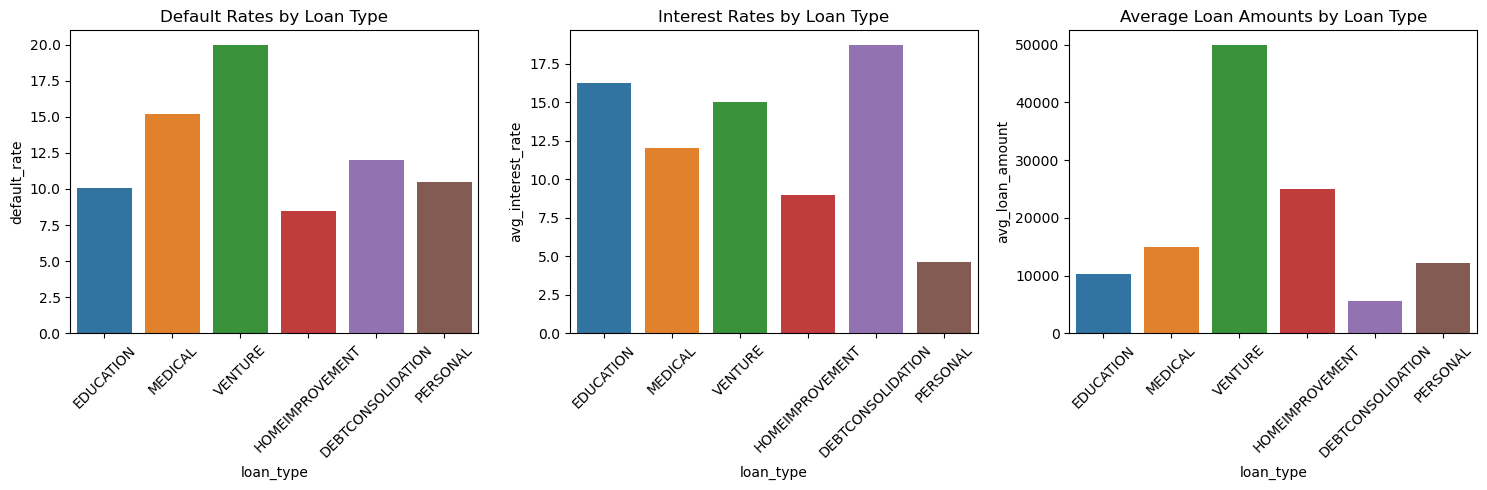

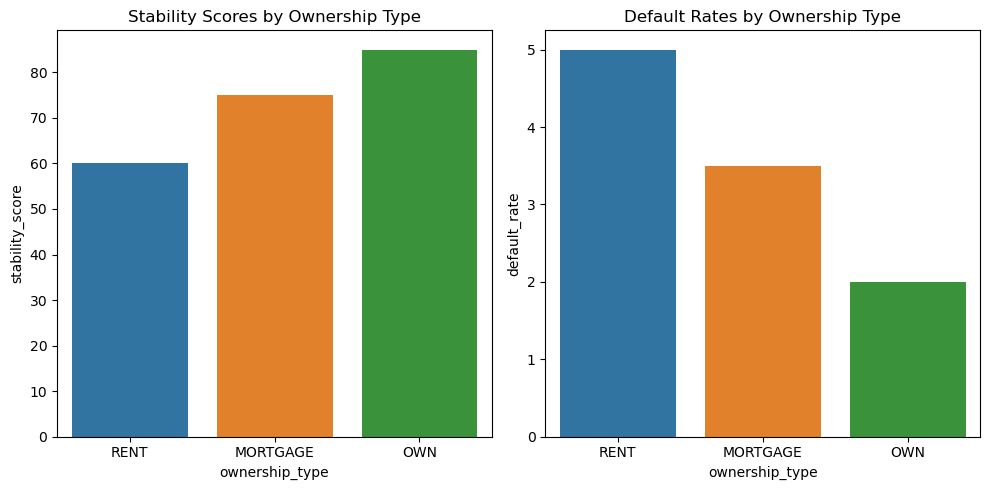

In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the raw data
loan_data = pd.read_csv('loan_data_raw.csv')
ownership_data = pd.read_csv('ownership_data_raw.csv')

# Create subplots for loan data
plt.figure(figsize=(15, 5))

# Plot loan metrics
plt.subplot(1, 3, 1)
sns.barplot(data=loan_data, x='loan_type', y='default_rate')
plt.title('Default Rates by Loan Type')
plt.xticks(rotation=45)

plt.subplot(1, 3, 2)
sns.barplot(data=loan_data, x='loan_type', y='avg_interest_rate')
plt.title('Interest Rates by Loan Type')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.barplot(data=loan_data, x='loan_type', y='avg_loan_amount')
plt.title('Average Loan Amounts by Loan Type')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Create subplots for ownership data
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
sns.barplot(data=ownership_data, x='ownership_type', y='stability_score')
plt.title('Stability Scores by Ownership Type')

plt.subplot(1, 2, 2)
sns.barplot(data=ownership_data, x='ownership_type', y='default_rate')
plt.title('Default Rates by Ownership Type')

plt.tight_layout()
plt.show()


# Web Crawling for Credit Risk Assessment Enhancement

## Project Overview

This documentation explains how we enhanced a credit risk dataset by web crawling additional features from financial websites. The goal was to enrich our credit risk assessment model with real-world market data about different loan types and home ownership categories.

## Original Dataset Features
The base dataset from Kaggle included:
- person_age
- person_income
- person_home_ownership
- person_emp_length
- loan_intent
- loan_grade
- loan_amnt
- loan_int_rate
- loan_status
- loan_percent_income
- cb_person_default_on_file
- cb_person_cred_hist_length


## Web Crawling Implementation

### 1. Data Sources
We crawled data from multiple reputable financial websites:
- Bankrate
- NerdWallet
- LendingTree

For each loan type and home ownership category, we used multiple sources to ensure robust data collection.

### 2. Technical Implementation
The web crawler was implemented using Python with the following key libraries:
- `requests`: For basic HTTP requests
- `BeautifulSoup4`: For HTML parsing
- `Selenium`: For dynamic content loading
- `fake_useragent`: For rotating user agents
- `pandas`: For data manipulation

### 3. Crawling Strategy
We implemented a robust crawling strategy with:
- Random delays between requests (2-4 seconds)
- User agent rotation
- Error handling and logging
- Fallback values for missing data
- Both static and dynamic (Selenium) web scraping capabilities


## Data Collection and Processing

### 1. Loan Intent Data Collection
For each loan type (EDUCATION, MEDICAL, VENTURE, etc.), we collected:
- Default rates
- Interest rates
- Average loan amounts
- Risk factors

Example of data processing for loan intent:
```python
risk_score = 0
if stats['default_rate']:
    risk_score += min(stats['default_rate'] / 25, 1) * 0.4  # Normalize to max 25% default rate
if stats['avg_interest_rate']:
    risk_score += min(stats['avg_interest_rate'] / 25, 1) * 0.3  # Normalize to max 25% interest rate
if stats['avg_loan_amount']:
    risk_score += min(stats['avg_loan_amount'] / 100000, 1) * 0.3  # Normalize to $100k
```

### 2. Home Ownership Data Collection
For each ownership type (RENT, MORTGAGE, OWN), we collected:
- Stability scores
- Default rates
- Market trends

Example of data processing for home ownership:
```python
risk_score = 0
if stats['stability_score']:
    risk_score += (100 - stats['stability_score']) / 100 * 0.6  # Higher stability = lower risk
if stats['default_rate']:
    risk_score += min(stats['default_rate'] / 10, 1) * 0.4  # Normalize to max 10% default rate
```


## Feature Engineering Results

### New Features Added
1. `loan_intent_risk_score` (range: 0.26-0.37)
   - Combines default rates, interest rates, and loan amounts
   - Higher scores indicate higher risk
   - Weighted components: default rate (40%), interest rate (30%), loan amount (30%)

2. `home_ownership_risk_score` (range: 0.17-0.44)
   - Combines stability scores and default rates
   - Higher scores indicate higher risk
   - Weighted components: stability (60%), default rate (40%)

3. `combined_risk_score` (range: 0.22-0.40)
   - Weighted combination of loan intent and home ownership risk scores
   - Formula: `loan_intent_risk_score * 0.6 + home_ownership_risk_score * 0.4`

### Risk Score Patterns

#### Home Ownership Risk Patterns:
- RENT: Highest risk (0.44)
- MORTGAGE: Medium risk (0.29)
- OWN: Lowest risk (0.17)

#### Loan Intent Risk Patterns:
- VENTURE and MEDICAL: Higher risk
- EDUCATION: Moderate risk
- PERSONAL: Lower risk

All scores are normalized to a 0-1 scale, making them easily interpretable and comparable across different risk dimensions.


## Why Web Crawling for Feature Enhancement?

1. **Real-World Market Data**
   - Web crawling allows us to incorporate current market trends and risk assessments
   - Financial websites provide aggregated insights from multiple lenders and market analysts
   - Helps capture dynamic market conditions that static historical data might miss

2. **Multiple Data Sources**
   - Cross-referencing multiple sources increases data reliability
   - Different perspectives from various financial institutions
   - Reduces bias from any single source

3. **Enriched Risk Assessment**
   - Traditional credit risk models often rely solely on individual borrower characteristics
   - Our web-crawled features add market-level risk assessment
   - Combines individual credit metrics with broader market risk indicators

4. **Automated Updates**
   - The web crawler can be scheduled to run periodically
   - Keeps risk scores current with market conditions
   - Allows for dynamic risk assessment adjustments

5. **Cost-Effective Solution**
   - Web crawling provides a cost-effective way to gather market data
   - Alternative would be expensive financial data subscriptions
   - Maintains data freshness without significant ongoing costs


## Code Example: Loading and Viewing Enhanced Dataset

Here's how to load and examine the enhanced dataset with our new features:


In [13]:
import pandas as pd

# Load the enhanced dataset
df = pd.read_csv('C:/Users/leemi/Techlent ML camp/Group_project/credit-risk-dataset/enhanced_credit_risk_dataset.csv')

# Display the first few rows with our new features
print("Sample of Enhanced Dataset:")
print(df[['loan_intent', 'person_home_ownership', 
          'loan_intent_risk_score', 'home_ownership_risk_score', 
          'combined_risk_score']].head())

# Display summary statistics of our new risk scores
print("\nRisk Score Statistics:")
print("\nLoan Intent Risk Score:")
print(df['loan_intent_risk_score'].describe())
print("\nHome Ownership Risk Score:")
print(df['home_ownership_risk_score'].describe())
print("\nCombined Risk Score:")
print(df['combined_risk_score'].describe())


Sample of Enhanced Dataset:
  loan_intent person_home_ownership  loan_intent_risk_score  \
0    PERSONAL                  RENT                0.259802   
1   EDUCATION                   OWN                0.387553   
2     MEDICAL              MORTGAGE                0.432200   
3     MEDICAL                  RENT                0.432200   
4     MEDICAL                  RENT                0.432200   

   home_ownership_risk_score  combined_risk_score  
0                       0.44             0.331881  
1                       0.17             0.300532  
2                       0.29             0.375320  
3                       0.44             0.435320  
4                       0.44             0.435320  

Risk Score Statistics:

Loan Intent Risk Score:
count    32581.000000
mean         0.420098
std          0.122597
min          0.259802
25%          0.319000
50%          0.432200
75%          0.433758
max          0.650000
Name: loan_intent_risk_score, dtype: float64

Home Owner